# FootballAnalysis
Group-Nr. 39

Friess Leon \
friesleo@students.zhaw.ch \
W.BA.WIN.21HS.VZBISc

Murtaj Drin \
murtadri@students.zhaw.ch \
W.BA.WIN.21HS.VZBISc

# Table of contents

* [Data Collection - ***Pt. (1) Add. Pt. (1)***](#kap_1)<br>
    * [Web Scraping with BeuautifulSoup](#kap_1_1)<br>
    * [Web API Overpass](#kap_1_2)<br>
* [Data Preperation - ***Pt. (2)***](#kap_2)<br>
    * [Data of the Web Scraping](#kap_2_1)<br>
    * [Data of the Web API](#kap_2_2)<br>
* [Data Storage in MySQL - ***Pt. (3) Add. Pt. (2)***](#kap_3)<br>
* [Non-graphical and graphical explatory data analysis (EDA) - ***Pt. (4), (6), (7)***](#kap_4)<br>
    * [Non-graphical](#kap_4_1)<br>
        * [Summary statistics of non-numeric variables](#kap_4_1_1)<br>
        * [Summary statistics of numeric variables](#kap_4_1_2)<br>
        * [Quantiles](#kap_4_1_3)<br>
        * [Skewness](#kap_4_1_4)<br>
        * [Kurtosis](#kap_4_1_5)<br>
    * [Graphical](#kap_4_2)<br>
        * [Histogram](#kap_4_2_1)<br>
        * [Piechart](#kap_4_2_2)<br>
        * [Boxplot](#kap_4_2_3)<br>
        * [Map - ***Add. Pt. (3)***](#kap_4_2_4)<br>
        * [WordCloud](#kap_4_2_5)<br>
* [Simple linear regression - ***Pt. (5)***](#kap_5)<br>
    * [k-means Clustering - ***Add. Pt. (5)***](#kap_5_1)<br>
* [Statistical test for the analysis of contigency tables - ***Add. Pt. (4)***](#kap_6)<br>
    * [Create new categorical variable based on ValueInMillionEuros](#kap_6_1)<br>
    * [Create new categorical variable based on the age](#kap_6_2)<br>
    * [Create contingency table with number of Players for AgeCat versus ValueCat](#kap_6_3)<br>
    * [Select part of the contingency table](#kap_6_4)<br>
    * [Perform Chi-square test](#kap_6_5)<br>
* [Making the material available - ***Pt. (8)***](#kap_7)<br> 

# Libraries

In [1]:
# Required
#!pip install mysql-connector-python

# Libraries
import folium
import json
import matplotlib.pyplot as plt
import mysql.connector as sql
import pandas as pd
import requests
import scipy.stats as stats
import seaborn as sns

from bs4 import BeautifulSoup
from pandas import json_normalize
from scipy.stats import chi2
from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data Collection
<a id='kap_1'></a>
*(1) Data collection using both, Web Scraping and a Web API*

***Additional point:*** *(1) Creativity of implementation (creative is anything not specified in the lessons and exercises)*

## Web Scraping with BeautifulSoup
<a id='kap_1_1'></a>

In [2]:
# Header for the GET request
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36 Edg/107.0.1418.52'}
pageSoupList = []

# Request the Transfermarkt for the 150 most valuable players (Page 1 to 6)
for i in range(1,7):
    page = "https://www.transfermarkt.com/marktwertetop/wertvollstespieler?ajax=yw1&page={}".format(i)
    pageTree = requests.get(page, headers=headers)
    pageSoupList.append(BeautifulSoup(pageTree.content, 'html.parser'))

In [3]:
# Creating lists for the different properties
NameList = []
AgeList = []
PositionList = []
ValueList = []
ClubList = []

In [4]:
# Creating lists for the different elements of the Transfermarkt page
Name = []
Age = []
Position = []
Value = []
Club = []

# Filling in the lists with the corresponding elements of the Transfermakrt page
for i in range(0,6):
    Name += pageSoupList[i].find_all("img", {"class": "bilderrahmen-fixed"})
    Age += pageSoupList[i].find_all("td", {"class": "zentriert"})
    Position += pageSoupList[i].find_all(string=["Goalkeeper", "Sweeper", "Centre-Back", "Left-Back", "Right-Back", "Full-Back",
                                                 "Defensive Midfield", "Central Midfield", "Right Midfield", "Left Midfield",
                                                 "Attacking Midfield", "Left Winger", "Attacking Midfield", "Left Winger",
                                                 "Right Winger", "Winger", "Second Striker", "Centre-Forward"])
    Value += pageSoupList[i].find_all("a")
    Club += pageSoupList[i].find_all("img", {"class": ""})

## Web API Overpass
<a id='kap_1_2'></a>

In [5]:
# Overpass API URL
url = 'http://overpass-api.de/api/interpreter'

# Overpass query
query = f"""[out:json];
            area[name="Zürich"];
            (
                way["leisure"="pitch"]["sport"="soccer"](area);
            );
            out center;"""

# Web API request
r = requests.get(url, params={'data': query})
data = r.json()['elements']

# Store data in data frame
df_pitches_raw = json_normalize(data)
df_pitches_raw.head(3)

,type,id,nodes,center.lat,center.lon,tags.leisure,tags.name,tags.sport,tags.surface,tags.lit,...,tags.landuse,tags.addr:country,tags.building,tags.email,tags.phone,tags.sport_1,tags.name:de,tags.name:en,tags.highway,tags.opening_date
0,way,9510900,"[73260268, 73260269, 8916999896, 73260270, 891...",47.320133,8.527146,pitch,Tüfi,soccer,grass,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,way,10117499,"[83395740, 83395742, 83395743, 83395744, 83395...",47.293271,8.540611,pitch,NaN,soccer,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,way,10310533,"[87090018, 87090020, 87090021, 87090022, 87090...",47.408275,8.634740,pitch,NaN,soccer,grass,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Number of rows
print('Number of rows:', df_pitches_raw.shape[0])

# Number of columns
print('Number of columns:', df_pitches_raw.shape[1])

Number of rows: 753
Number of columns: 44


# Data Preparation
<a id='kap_2'></a>
*(2) Data preparation (e.g. remove missing values and duplicates, create new variables, enrich the data with open data)*

## Data of the Web Scraping
<a id='kap_2_1'></a>

In [7]:
# Filling the list with only the age element of the players
AgeClean = []

#Player 1-25
for i in range(1,98,4):
    AgeClean.append(Age[i])

#Player 26-50
for i in range(116,213,4):
    AgeClean.append(Age[i])
    
#Player 51-75
for i in range(231,328,4):
    AgeClean.append(Age[i])
    
#Player 76-100
for i in range(346,443,4):
    AgeClean.append(Age[i])
    
#Player 101-125
for i in range(461,558,4):
    AgeClean.append(Age[i])
    
#Player 126-150
for i in range(576,673,4):
    AgeClean.append(Age[i])

In [8]:
# Filling the list with only the position element of the players
PositionClean = []

#Player 1-25
for i in range(17,42,1):
    PositionClean.append(Position[i])
    
#Player 26-50
for i in range(59,83,1):
    PositionClean.append(Position[i])
    
#Player 51-75
for i in range(100,125,1):
    PositionClean.append(Position[i])
    
#Player 76-100
for i in range(142,167,1):
    PositionClean.append(Position[i])
    
#Player 101-125
for i in range(184,209,1):
    PositionClean.append(Position[i])
    
#Player 126-150
for i in range(226,252,1):
    PositionClean.append(Position[i])

In [9]:
# Filling the list with only the value element of the players
ValueClean = []

#Player 1-25
for i in range(19,116,4):
    ValueClean.append(Value[i])
    
#Player 26-50
for i in range(182,279,4):
    ValueClean.append(Value[i])
    
#Player 51-75
for i in range(347,444,4):
    ValueClean.append(Value[i])
    
#Player 76-100
for i in range(512,609,4):
    ValueClean.append(Value[i])
    
#Player 101-125
for i in range(677,774,4):
    ValueClean.append(Value[i])
    
#Player 126-150
for i in range(842,939,4):
    ValueClean.append(Value[i])

In [10]:
# Filling the lists with only the corresponding value by removing HTML code
for i in range(len(Name)):
    NameList.append(str(Name[i]).split('" class',1)[0].split('<img alt="',1)[1])
    
    
for i in range(len(AgeClean)):
    AgeList.append(int(AgeClean[i].text))
    
    
for i in range(len(PositionClean)):
    PositionList.append(str(PositionClean[i].text))
    
    
for i in range(len(ValueClean)):
    ValueList.append(str(ValueClean[i]).split('.00m</a>',1)[0].split('">€',1)[1])
    
    
for i in range(len(Club)):
    ClubList.append(str(Club[i]).split('" class',1)[0].split('<img alt="',1)[1])

In [11]:
# Change type of ValueList from string to int
ValueListClean = [int(x) for x in ValueList]

In [12]:
# Filling the list with the clean club-names of the players
ClubListClean = []

#Player 1-25
for i in range(0,25,1):
    ClubListClean.append(ClubList[i])
    
#Player 26-50
for i in range(36,61,1):
    ClubListClean.append(ClubList[i])
    
#Player 51-75
for i in range(72,97,1):
    ClubListClean.append(ClubList[i])
    
#Player 76-100
for i in range(108,133,1):
    ClubListClean.append(ClubList[i])
    
#Player 101-125
for i in range(144,169,1):
    ClubListClean.append(ClubList[i])
    
#Player 126-150
for i in range(180,205,1):
    ClubListClean.append(ClubList[i])

In [13]:
# Creating dataframe with the lists
df_players = pd.DataFrame({"Name":NameList,
                                       "Age":AgeList,
                                       "Position":PositionList,
                                       "ValueInMillionEuros":ValueListClean,
                                       "Club":ClubListClean})

In [14]:
df_players

,Name,Age,Position,ValueInMillionEuros,Club
0,Erling Haaland,22,Centre-Forward,170,Manchester City
1,Kylian Mbappé,24,Centre-Forward,160,Paris Saint-Germain
2,Vinicius Junior,22,Left Winger,120,Real Madrid
3,Phil Foden,22,Central Midfield,110,Manchester City
4,Pedri,20,Central Midfield,100,FC Barcelona
...,...,...,...,...,...
145,Emile Smith Rowe,22,Attacking Midfield,38,Arsenal FC
146,Sven Botman,22,Centre-Back,38,Newcastle United
147,Frank Anguissa,27,Defensive Midfield,38,SSC Napoli
148,Ben Chilwell,26,Left-Back,38,Chelsea FC


## Data of the Web API
<a id='kap_2_2'></a>

In [15]:
# Taking the required columns of the dataframe
df_pitches = df_pitches_raw[['id', 'center.lat', 'center.lon', 'tags.name', 'tags.surface']].copy()

# Renaming the columns
df_pitches = df_pitches.rename({"id":"ID", "center.lat":"Latitude", "center.lon":"Longitude", "tags.name":"Name", "tags.surface":"Surface"}, axis='columns')

# Removing rows with NaN entries
df_pitches = df_pitches.dropna()

df_pitches.head(5)

,ID,Latitude,Longitude,Name,Surface
0,9510900,47.320133,8.527146,Tüfi,grass
4,10697056,47.421113,8.510508,Fronwald R3,grass
5,10697068,47.421696,8.508944,Fronwald R4,grass
15,11656926,47.379074,8.496965,Utogrund R1,grass
16,14938676,47.380905,8.478391,Buchlern KR11,artificial_turf


In [16]:
# Number of rows
print('Number of rows:', df_pitches.shape[0])

# Number of columns
print('Number of columns:', df_pitches.shape[1])

Number of rows: 101
Number of columns: 5


# Data Storage in MySQL
<a id='kap_3'></a>
*(3) Data storage in a database like sqlite or MySQL*

***Additional point:*** *(2) Use of a MySQL database for data storage and SQL-queries from within Python*

In [17]:
# Connection to the MySQL database
mydb = sql.connect(
  host="localhost",
  user="root",
  passwd="root",
  database="db_players"
)

mycursor = mydb.cursor()

# Creating the database
mycursor.execute("CREATE DATABASE IF NOT EXISTS db_players")

# Creating the table
mycursor.execute("CREATE TABLE IF NOT EXISTS tbl_players (id int PRIMARY KEY AUTO_INCREMENT, name VARCHAR(50),age smallint UNSIGNED, position VARCHAR(50), value smallint UNSIGNED, club VARCHAR(50))")

# Filling the table with the corresponding values
for i in range(len(NameList)):
    sql = "INSERT INTO tbl_players (name, age, position, value, club) VALUES (%s, %s, %s, %s, %s)"
    val = (NameList[i], AgeList[i], PositionList[i], ValueListClean[i], ClubListClean[i])
    mycursor.execute(sql, val)
    
# Commiting the db
mydb.commit()

print("The players have been added to the table tbl_players.\n")
print("First five entries of tbl_players:")

# Printing out the first 5 entries of the db
mycursor.execute("SELECT * FROM tbl_players LIMIT 5")

myresult = mycursor.fetchall()

for x in myresult:
  print(x)


The players have been added to the table tbl_players.

First five entries of tbl_players:
(1, 'Erling Haaland', 22, 'Centre-Forward', 170, 'Manchester City')
(2, 'Kylian Mbappé', 23, 'Centre-Forward', 160, 'Paris Saint-Germain')
(3, 'Vinicius Junior', 22, 'Left Winger', 120, 'Real Madrid')
(4, 'Phil Foden', 22, 'Central Midfield', 110, 'Manchester City')
(5, 'Pedri', 20, 'Central Midfield', 100, 'FC Barcelona')


# Non-graphical and graphical exploratory data analysis (EDA)
<a id='kap_4'></a>
*(4) Non-graphical and graphical exploratory data analysis (EDA)*

*(6) Model evaluation using suitable measures of fit*

*(7) Correct interpretation of model results and measures of fit*

## Non-graphical
<a id='kap_4_1'></a>

### Summary statistics of non-numeric variables
<a id='kap_4_1_1'></a>

In [18]:
# Skipped the column 'name' and renamed the required rows
df_players.iloc[:,1:].describe(include=[object]).rename({"count":"Count",
                                                         "unique":"Unique",
                                                         "top":"Top",
                                                         "freq":"Frequency"}, axis='rows')

,Position,Club
Count,150,150
Unique,12,37
Top,Centre-Back,Bayern Munich
Frequency,29,11


### Summary statistics of numeric variables
<a id='kap_4_1_2'></a>

In [19]:
df_players.describe().round(1)

,Age,ValueInMillionEuros
count,150.0,150.0
mean,24.9,59.2
std,3.1,20.9
min,18.0,38.0
25%,23.0,45.0
50%,25.0,55.0
75%,27.0,70.0
max,35.0,170.0


### Quantiles
<a id='kap_4_1_3'></a>

In [20]:
df_players.quantile(q=[0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95]).round(1)

,Age,ValueInMillionEuros
0.05,20.0,38.9
0.10,21.0,40.0
0.25,23.0,45.0
0.50,25.0,55.0
0.75,27.0,70.0
0.90,29.0,80.0
0.95,30.0,95.5


### Skewness
<a id='kap_4_1_4'></a>

In [21]:
df_players.skew()

Age                    0.354923
ValueInMillionEuros    2.180161
dtype: float64

### Kurtosis
<a id='kap_4_1_5'></a>

In [22]:
df_players.kurtosis()

Age                    0.108939
ValueInMillionEuros    7.751284
dtype: float64

## Graphical
<a id='kap_4_2'></a>

### Histogram
<a id='kap_4_2_1'></a>

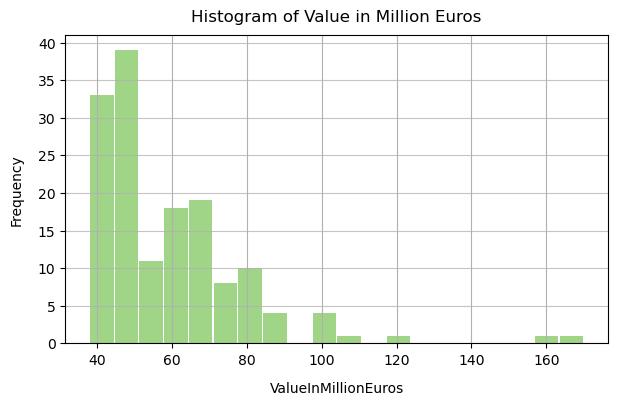

In [23]:
# Plot Histogram
fig = plt.figure( figsize=(7,4))
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
n, bins, patches = plt.hist(x=df_players['ValueInMillionEuros'], 
                            bins=20, 
                            color='#42AD12',
                            alpha=0.5, 
                            rwidth=0.95)
plt.grid(True)
plt.ticklabel_format(style='plain')
plt.grid(axis='y', alpha=0.75)

# Set labels
plt.xlabel('ValueInMillionEuros', fontsize=10, labelpad=10)
plt.ylabel('Frequency', fontsize=10, labelpad=10)
plt.title('Histogram of Value in Million Euros', fontsize=12, pad=10)

# Set fontsize of tick labels
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

### Piechart
<a id='kap_4_2_2'></a>

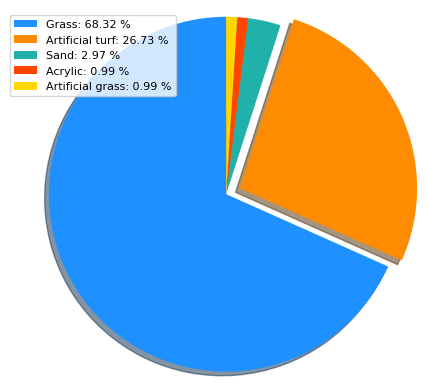

In [24]:
# Creating Pie Names
x = 'Grass','Artificial turf','Sand', 'Acrylic','Artificial grass'

# Taking corresponding values
y = df_pitches['Surface'].value_counts()

# Formatting the piechart
colors = ['dodgerblue','darkorange','lightseagreen','orangered','gold']
porcent = 100.*y/y.sum()
explode = (0, 0.1, 0, 0, 0)

# Formatting the legend
patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2, explode=explode, shadow=True)
labels = ['{0}: {1:1.2f} %'.format(i,j) for i,j in zip(x, porcent)]

# Sorting the legend
sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

# Positioning the legend
plt.legend(patches, labels, loc='upper left', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)

### Boxplot
<a id='kap_4_2_3'></a>

<AxesSubplot: xlabel='ValueInMillionEuros'>

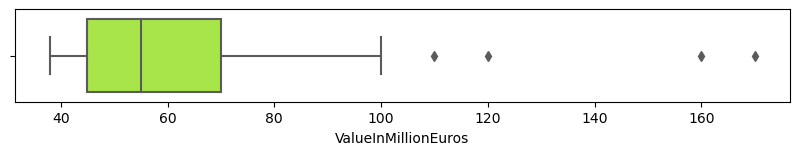

In [25]:
# Creating the boxplot
plt.figure(figsize=(10,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=df_players['ValueInMillionEuros'], color="greenyellow")

### Map
<a id='kap_4_2_4'></a>
***Additional point:*** *(3) Integration and visualization of geographical data*

In [26]:
# Create map
map_pitches = folium.Map(location=[df_pitches.Latitude.mean(), 
                           df_pitches.Longitude.mean()], 
                 zoom_start=8.5, 
                 control_scale=True)

# Add marker symbols
for index, location_info in df_pitches.iterrows():
    folium.Marker([location_info["Latitude"], 
                   location_info["Longitude"]], 
                   popup=location_info["Name"]).add_to(map_pitches)

# Plot map
map_pitches

### WordCloud
<a id='kap_4_2_5'></a>

In [27]:
# Removing the spaces between the club names
ClubListCleanNoSpaces = []

for i in range(len(ClubListClean)):
    ClubListCleanNoSpaces.append(ClubListClean[i].replace(" ", ""))

In [28]:
# Removing the dashes between the club names
ClubListCleanNoSpacesNoDash = []

for i in range(len(ClubListClean)):
    ClubListCleanNoSpacesNoDash.append(ClubListCleanNoSpaces[i].replace("-", ""))

In [29]:
# Creating a dataframe with the cleand club names
df_clubs = pd.DataFrame({"Club":ClubListCleanNoSpacesNoDash})

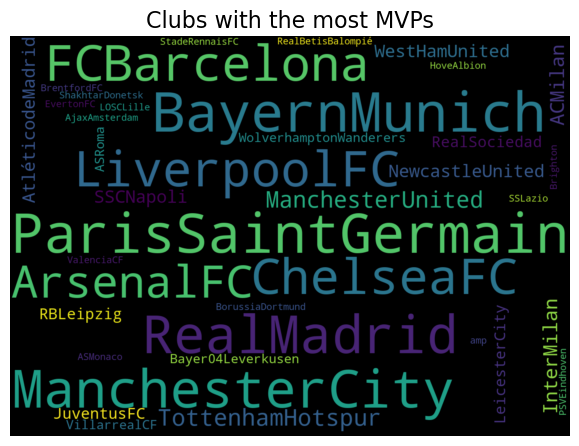

In [30]:
# Wordcloud function
def wordCloud_generator(df_clubs, title=None):
    
    wordcloud = WordCloud(height=1000,
                          width=1400,
                          background_color ='black',
                          min_font_size = 10
                         ).generate(" ".join(df_clubs.values))
    
    # Plot the WordCloud image                        
    plt.figure(figsize = (6, 4), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=16)
    plt.show()
    
# Create Wordcloud with the cleaned club names, so the the cloud is not distorted
wordCloud_generator(df_clubs['Club'], title="Clubs with the most MVPs")

In [31]:
# Printing the clubs with the most MVPs to compare it with the WordCloud
df_players['Club'].value_counts().head(10)

Bayern Munich          11
Paris Saint-Germain    11
Manchester City        10
Real Madrid            10
FC Barcelona            9
Chelsea FC              9
Liverpool FC            9
Arsenal FC              8
Tottenham Hotspur       7
Manchester United       7
Name: Club, dtype: int64

# Simple linear regression
<a id='kap_5'></a>
*(5) Use of either regression or classification as the modelling method*

In [32]:
#Create train and test samples (train = 80%, test = 20% of the data)

X_train, X_test, y_train, y_test = train_test_split(df_players['Age'], 
                                                    df_players['ValueInMillionEuros'], 
                                                    test_size=0.20, 
                                                    random_state=42)
# Show X_train
print('X_train:')
print(X_train.head(), '\n')

# Show y_train
print('y_train:')
print(y_train.head())

X_train:
22    22
15    26
65    30
11    23
42    28
Name: Age, dtype: int64 

y_train:
22    75
15    80
65    60
11    85
42    70
Name: ValueInMillionEuros, dtype: int64


In [33]:
#Fit the simple linear regression model
slope, intercept, r, p, std_err = stats.linregress(X_train, y_train)

# Print results of the regression model
print('Linear regression result:')
print(f'Intercept with y-axis (alpha):            {intercept:.2f}')
print(f'Slope of regression line (beta):          {slope:.3f}')
print(f'p-value:                                  {p:.4f}')
print(f'R-squared (coefficient of determination): {r**2:.4f}')

Linear regression result:
Intercept with y-axis (alpha):            97.92
Slope of regression line (beta):          -1.523
p-value:                                  0.0164
R-squared (coefficient of determination): 0.0478


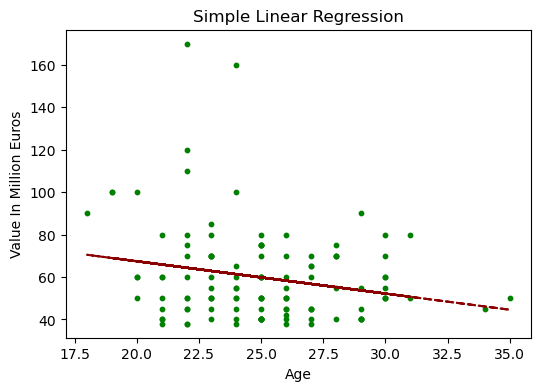

In [34]:
# Plot regression line
# Function to calculate model predictions
def myfunc(x):
    return slope * x + intercept

# Apply myfunc() to x, i.e. make predictions 
mymodel = pd.Series(map(myfunc, X_train))

# Scatterplot with regression line
plt.figure(figsize=(6,4))
plt.scatter(X_train, y_train, s=10, color='green')
plt.plot(X_train, mymodel, color='darkred', linestyle='dashed')
plt.title('Simple Linear Regression')
plt.xlabel('Age')
plt.ylabel('Value In Million Euros')

plt.show()

In [35]:
# Check model residuals
residuals = mymodel - y_train

# Check the first residual value in our data set
print(f'1st Predicted value in dataset: {mymodel[0]:.2f}')
print(f'1st Observed value in dataset: {y_train[0]:.2f}')
print(f'1st Residual value in dataset: {residuals[0]:.2f}')

1st Predicted value in dataset: 64.40
1st Observed value in dataset: 170.00
1st Residual value in dataset: -105.60


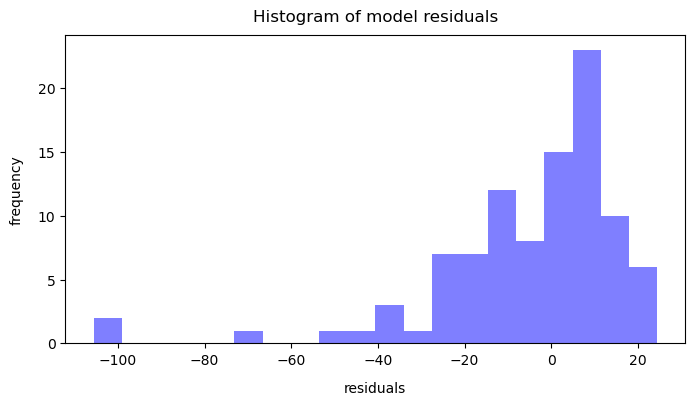

In [36]:
# Plot histogram of residuals
fig = plt.figure( figsize=(8,4))
n, bins, patches = plt.hist(x=residuals, 
                            bins=20, 
                            color='blue',
                            alpha=0.5)

# Set title and labels
plt.xlabel('residuals', fontsize=10, labelpad=10)
plt.ylabel('frequency', fontsize=10, labelpad=10)
plt.title('Histogram of model residuals', fontsize=12, pad=10)

# Show plot
plt.show()

In [37]:
# Compare the predicted values with the observed values in our test sample

# Create model predictions for test data
predicted = myfunc(X_test)
predicted.round(1)

# Compare predicted with observed value based on first 10 test samples
for i in range(0,10):
    print(f'Predicted value: {predicted.iloc[i]:.1f}, Observed value: {y_test.iloc[i]:.1f}')

Predicted value: 59.8, Observed value: 55.0
Predicted value: 55.3, Observed value: 80.0
Predicted value: 65.9, Observed value: 40.0
Predicted value: 67.5, Observed value: 50.0
Predicted value: 53.7, Observed value: 55.0
Predicted value: 62.9, Observed value: 70.0
Predicted value: 56.8, Observed value: 60.0
Predicted value: 55.3, Observed value: 40.0
Predicted value: 58.3, Observed value: 55.0
Predicted value: 62.9, Observed value: 50.0


##  k-means Clustering
<a id='kap_5_1'></a>
***Additional point:*** *(5) Use of k-means clustering in addition to the regression or classification model.*

In [38]:
# Define a subset of the data frame for k-means clustering
kmeans_sub = df_players[['Age',
         'ValueInMillionEuros']]

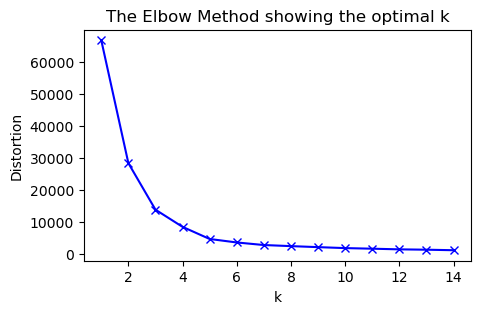

In [39]:
# Elbow method showing the optimal k

# Sum of squared distances of samples to their closest cluster center
distortions = []

# Range of k's
K = range(1,15)

# Loop to find the optimal k
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(kmeans_sub)
    distortions.append(kmeanModel.inertia_)
    
# Elbow plot
plt.figure(figsize=(5,3))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

plt.show()

In [40]:
# Perform k-means clustering on the players data

# Number of cluters
k = 5

# Perform k-means clustering
kmeans_players = KMeans(n_clusters=k, random_state=42).fit(kmeans_sub)

# Add the clusters to data frame
kmeans_sub['cluster'] = kmeans_players.predict(kmeans_sub)

# Show number of players per cluster
kmeans_sub['cluster'].value_counts().sort_values(ascending=False)


kmeans_players.inertia_

4577.581843803648

# Statistical test for the analysis of contingency tables
<a id='kap_6'></a>
***Additional Point***: *(4) Use of a statistical test for the analysis of contingency tables or analysis of variance (ANOVA)*

## Create new categorical variable based on ValueInMillionEuros
<a id='kap_6_1'></a>

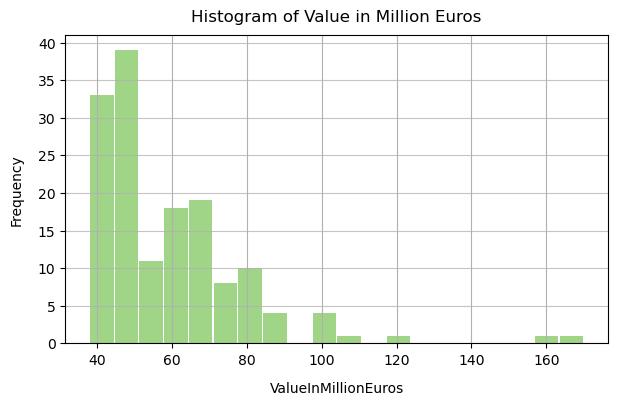

In [41]:
# Plot Histogram of ValueInMillionEuros
fig = plt.figure( figsize=(7,4))
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
n, bins, patches = plt.hist(x=df_players['ValueInMillionEuros'], 
                            bins=20, 
                            color='#42AD12',
                            alpha=0.5, 
                            rwidth=0.95)
plt.grid(True)
plt.ticklabel_format(style='plain')
plt.grid(axis='y', alpha=0.75)

 

# Set labels
plt.xlabel('ValueInMillionEuros', fontsize=10, labelpad=10)
plt.ylabel('Frequency', fontsize=10, labelpad=10)
plt.title('Histogram of Value in Million Euros', fontsize=12, pad=10)

 

# Set fontsize of tick labels
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

 

plt.show()

In [42]:
# Show quantiles of ValueInMillionEuros
qt_price = df_players['ValueInMillionEuros'].quantile(q=[0.10, 0.25, 0.50, 0.75, 0.90])
qt_price

0.10    40.0
0.25    45.0
0.50    55.0
0.75    70.0
0.90    80.0
Name: ValueInMillionEuros, dtype: float64

In [43]:
# Create new categorical variable 'ValueCat'

# Create labels
labels = ['0 - 49', '50 - 99', '100 - 149', '>= 150']

# Create new categorical variable
df_players["ValueCat"] = pd.cut(df_players.ValueInMillionEuros, bins=[0, 50, 100, 149, 200], labels=labels)

# Check values
df_players[['ValueInMillionEuros', 'ValueCat']].head(10)

,ValueInMillionEuros,ValueCat
0,170,>= 150
1,160,>= 150
2,120,100 - 149
3,110,100 - 149
4,100,50 - 99
5,100,50 - 99
6,100,50 - 99
7,100,50 - 99
8,90,50 - 99
9,90,50 - 99


## Create new categorical variable based on the age
<a id='kap_6_2'></a>

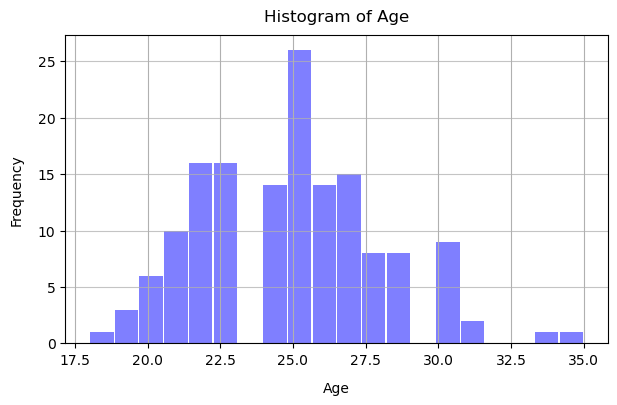

In [44]:
# Plot Histogram of age
fig = plt.figure( figsize=(7,4))
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
n, bins, patches = plt.hist(x=df_players['Age'], 
                            bins=20, 
                            color='blue',
                            alpha=0.5, 
                            rwidth=0.95)
plt.grid(True)
plt.ticklabel_format(style='plain')
plt.grid(axis='y', alpha=0.75)

# Set labels
plt.xlabel('Age', fontsize=10, labelpad=10)
plt.ylabel('Frequency', fontsize=10, labelpad=10)
plt.title('Histogram of Age', fontsize=12, pad=10)

# Set fontsize of tick labels
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

In [45]:
# Show quantiles of age
qt_area = df_players['Age'].quantile(q=[0.10, 0.25, 0.50, 0.75, 0.90])
qt_area

0.10    21.0
0.25    23.0
0.50    25.0
0.75    27.0
0.90    29.0
Name: Age, dtype: float64

In [46]:
# Create new categorical variable 'AgeCat'

# Create labels
labels = ['15 - 19', '20 - 24', '25 - 29', '30 - 34', '>= 35']

# Create new categorical variable
df_players["AgeCat"] = pd.cut(df_players.Age, bins=[15, 20, 25, 30, 34, 60], labels=labels)

# Check values
df_players[['Age', 'AgeCat']].head(10)

,Age,AgeCat
0,22,20 - 24
1,24,20 - 24
2,22,20 - 24
3,22,20 - 24
4,20,15 - 19
5,19,15 - 19
6,19,15 - 19
7,24,20 - 24
8,18,15 - 19
9,21,20 - 24


## Create contingency table with number of Players for AgeCat versus ValueCat
<a id='kap_6_3'></a>

In [47]:
# Contingency table (numbers in the table are players)
tab = pd.pivot_table(df_players[['Name', 'AgeCat', 'ValueCat']],
                     index=['AgeCat'],
                     columns=['ValueCat'], 
                     aggfunc='count')
tab

Name                         
ValueCat 0 - 49 50 - 99 100 - 149 >= 150
AgeCat                                  
15 - 19       3       7         0      0
20 - 24      38      40         2      2
25 - 29      28      26         0      0
30 - 34       2       1         0      0
>= 35         1       0         0      0

## Select part of the contingency table
<a id='kap_6_4'></a>

In [48]:
# Select part of the contigency table
tab_sub = tab.iloc[0:2,0:2]
tab_sub

Name        
ValueCat 0 - 49 50 - 99
AgeCat                 
15 - 19       3       7
20 - 24      38      40

## Perform Chi-square test
<a id='kap_6_5'></a>

In [49]:
# 1-alpha
prob = 0.95

# Chi-squared test
stat, p, dof, expected = chi2_contingency(tab_sub)

# Critical value
critical = chi2.ppf(prob, dof)

# Print results of the Chi-square test
print('Expected frequencies:', '\n', expected.round(4), '\n')
print('Critical value:', critical.round(4), '\n')
print('Test statistic:', stat.round(4), '\n')
print('Degrees of freedom:', dof, '\n')
print(f'p-value: {p:.4f}')

Expected frequencies: 
 [[ 4.6591  5.3409]
 [36.3409 41.6591]] 

Critical value: 3.8415 

Test statistic: 0.6091 

Degrees of freedom: 1 

p-value: 0.4351


# Making the material available
<a id='kap_7'></a>
*(8) Making the material (data, Jupyter notebooks, ...) available on Moodle*

The Notebook will be submitted as an .ipynb File, as well as an HTML.